 # Binary clssification : CNN , data augmented on the fly with gaussian filter and time shift

on teste ici deux modèles:
* la même architecture que le modèle CNN utilisé précédemment
* une nouvelle architecture: celle ci contient deux couches de convolution successives de même kernel, comme cela est souvent fait


On utilise cette fois les deux jeux de données en transformant la classification du premier en normal/anormal

l'augmentaion des données se fait dans le bacth pour avoir un modèle qui optimize des features non dépendantes du numéro d'échantillon
  

on applique donc un décalage temporel de l'ensemble du signal. la décalage est au maximum le nombre d'échantillons de zero padding
on applique aussi un léger filtre gaussien, léger car les pics de faibles largeurs sont fortement impactés.

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim
from sklearn.model_selection import train_test_split
import joblib

In [2]:
from scipy import ndimage
import  seaborn as sns

## DATASETS

## STEP 1: Classification Normal/Abnormal

In [5]:
#dataset 2 classe 1
X2_1,y2_1 = load_balanced.load('../data/raw/ptbdb_abnormal.csv')
#dataset 2 classe 0
X2_0,y2_0 = load_balanced.load('../data/raw/ptbdb_normal.csv')
#dataset 1 multi classes
X1,y1 = load_balanced.load('../data/raw/mitbih_train.csv')

In [6]:
# transforme tout ce qui n'est pas classe 0 en classe 1
y1[y1>0]=1
# concat base 2
X2 = np.concatenate((X2_1,X2_0))
y2 = np.concatenate((y2_1,y2_0))
# compate

In [7]:
print(pd.Series(y2).value_counts())
print(pd.Series(y1).value_counts())

1.0    10506
0.0     4046
Name: count, dtype: int64
0.0    72471
1.0    15083
Name: count, dtype: int64


 au total j'ai 10506+15083 = 25589 signaux de classe 1.
 
 il m'en faut autant de la classe 0.
 
 j'en ai 4046 dans le dataset 2, il faut que j'en prenne 21553 du dataset 1

In [8]:
n_classe0_in_dataset1 = 21553

In [9]:
# ok don on va undersampler la classe 0 du dataset 1
print(X1.shape)
ii = np.arange(X1.shape[0])
np.random.shuffle(ii)
# deja on shuffle si jamais les classes sont dans un ordre particulier
Xs = X1[ii,:]
ys = y1[ii]
print(Xs.shape)

(87554, 187)
(87554, 187)


In [10]:
c0 = [k for k,x in enumerate(ys) if x==0] # indices des sgnaux de classe 0
c1 = [k for k,x in enumerate(ys) if x==1] # indices des sgnaux de classe 1
# et je vais prendre n_classe0_in_dataset1 signaux de la classe 0 et tous les signaux de la classe 1
c0 = c0[0:n_classe0_in_dataset1]

X1p = np.concatenate((Xs[c0,:],Xs[c1,:]))
y1p=  np.concatenate((ys[c0],ys[c1]))

# et puis on reshuffle le tout car la c'est dans l'ordre 0/1
ii = np.arange(X1p.shape[0])
np.random.shuffle(ii)
X1p = X1p[ii,:]
y1p = y1p[ii]

In [9]:
X = np.concatenate((X1p,X2))
y = np.concatenate((y1p,y2))
print(pd.Series(y).value_counts())

0.0    25599
1.0    25589
Name: count, dtype: int64


In [10]:
X_train,X_cross, y_train, y_cross = train_test_split(X,y,test_size=0.1,random_state=12)

A ce stade j'un un dataset conséquent qui n'a pas d'oversample. on peut déjà essayer ca

### conversion en pytorch dataset

In [11]:
X_train = np.expand_dims(X_train,axis=1)
X_cross =np.expand_dims(X_cross,axis=1)

In [12]:


train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

In [13]:
X_train.shape

(46069, 1, 187)

## Construction d'un filtre gaussien depuis un tensor. 

Gaussians conv and signal roll on the fly

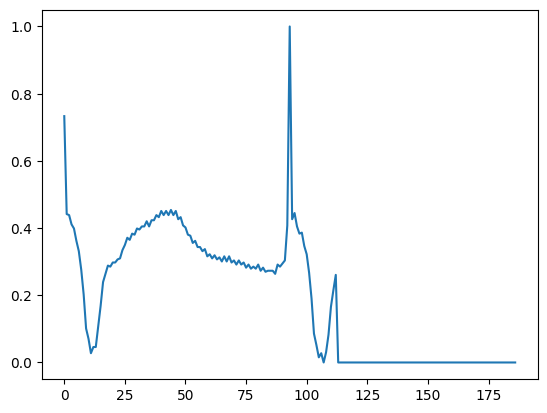

In [14]:
X_batch,y_batch = next(iter(train_loader))
plt.plot(X_batch[12,0,:].detach().numpy())

In [15]:
Gau = []
with torch.no_grad():
    for sigma in [0.5,0.7]:
        weights = ndimage._filters._gaussian_kernel1d(sigma, 0, int(4 * sigma + 0.5))[::-1]
        conv = nn.Conv1d(1, 1, weights.shape[0], stride=1, padding='same',bias=False)
        for k in range(conv.weight.shape[2]):
            conv.weight[0,0,k]= torch.tensor(weights[k])
        Gau.append(conv)

plt.plot(Gau[0].weight[0,0,:].detach().numpy(),label='weights gaussian 0.7')
plt.plot(Gau[1].weight[0,0,:].detach().numpy(),label='weights gaussian 1')
plt.plot(Gau[2].weight[0,0,:].detach().numpy(),label='weights gaussian 1')
plt.legend()

In [16]:
X_batch,y_batch = next(iter(train_loader))

X1_batch = Gau[0](X_batch)
X2_batch = Gau[1](X_batch)
X3_batch = Gau[2](X_batch)
plt.plot(X_batch[12,0,:].detach().numpy(),label='raw signal')
plt.plot(X1_batch[12,0,:].detach().numpy(),label='with nn.conv1d gaussian 0.7')
plt.plot(X2_batch[12,0,:].detach().numpy(),label='with nn.conv1d gaussian 1')
plt.plot(X3_batch[12,0,:].detach().numpy(),label='with nn.conv1d gaussian 1.2')
#plt.plot(ndimage.gaussian_filter1d(X_batch[12,0,:].detach().numpy(),0.7),label='with ndimage gaussian 0.7')
#plt.plot(ndimage.gaussian_filter1d(X_batch[12,0,:].detach().numpy(),1),label='with ndimage gaussian 1')
plt.legend()

In [17]:
def fly_shift_and_gauss(X_batch,Gau,n_Gauss=None,n_shift=None):
    with torch.no_grad():
        n_zeros_pad = ((X_batch.flip(dims=[2])!=0)).to(float).argmax(dim=2)
        n_zeros_pad = n_zeros_pad.detach().numpy().flatten()
        if n_Gauss is None:
            n_Gauss = X_batch.shape[0]
        if n_shift is None:
            n_shift = X_batch.shape[0]
        # apply gaussian filter randomnly to N signal
        # N must be at least the number of gussian filters defined : 3
        n_apply_gauss = X_batch.shape[0] //2 #np.random.randint(n_Gauss)
        # number of gaussian filter to apply
        n_filter_gauss = len(Gau)
        #if n_apply_gauss>=n_filter_gauss:
        index_apply_gauss = list(range(X_batch.shape[0]))
        np.random.shuffle(index_apply_gauss)
        # apply eahc gaussian to a part of the N signals 
        gn = int(n_apply_gauss/n_filter_gauss) # number of signals filtered by 1 gaussian
        for kg in range(n_filter_gauss):              
            ii_gauss = index_apply_gauss[kg*gn:(kg+1)*gn]        
            X_batch[ii_gauss,:,:] =  Gau[kg](X_batch[ii_gauss,:,:])

        n_apply_shift = X_batch.shape[0] //2 #np.random.randint(n_shift)
        #if n_apply_shift>1:
        index_apply_shift = list(range(X_batch.shape[0]))
        np.random.shuffle(index_apply_shift)
        ii_shift = index_apply_shift[0:n_shift]
     
        for ii in ii_shift:
            if n_zeros_pad[ii]>0:
                X_batch[ii,:,:] = X_batch[ii,:,:].roll(np.random.randint(n_zeros_pad[ii]),dims=[1])
    return X_batch

In [18]:
X_batch = fly_shift_and_gauss(X_batch,Gau)

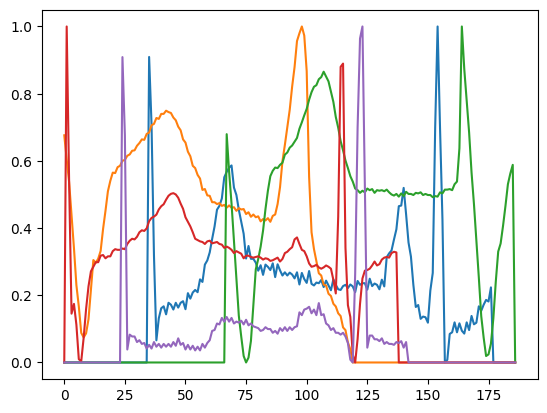

In [19]:
fig = plt.figure()
ax = fig.add_subplot()
for k in range(5):
    ax.plot(X_batch[k,0,:])

## fonctions d'entrainement et d'évaluation

In [20]:

def train_a_model_augment_on_the_fly(model,train_loader,test_set,epochs = 100,lr=1e-3,device='cpu',outmodelname=None):

    best_accuracy = 0
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=0.5,
                                                    patience=5,
                                                    verbose=True)
    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for batch in train_loader:
            # Batch de données
            X_batch, y_batch = batch
            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            X_batch = fly_shift_and_gauss(X_batch,Gau)
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()

        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)

        scheduler.step(loss_total/len(train_loader))

        if accuracy > best_accuracy and outmodelname is not None:
            joblib.dump(model, outmodelname)
            print('save model')
            best_accuracy = accuracy
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

In [21]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()

### nouvelle architecture de modèle

In [22]:
def newcnn(input_shape=187,device='cpu',dropout=0.4):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=0), # shape: (batch_size, n, 181)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=32),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 90)
        
        nn.Conv1d(in_channels=32, out_channels=48, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 86)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=48),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 43)
        
        nn.Conv1d(in_channels=48, out_channels=64, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 41)
        nn.ReLU(),
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 39)
        nn.ReLU(),        
        nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 37)
        nn.ReLU(),       
        nn.BatchNorm1d(num_features=32),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 18)
        
        nn.Flatten() , # shape: (batch_size, 10*n)
        nn.Dropout(dropout),
        nn.Linear(18*32, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
   

### ancienne architecture de modèle

j'ai juste ajouté une couche Dense dans le calssifieur

In [23]:
def oldcnnmodified(input_shape=187,device='cpu',dropout=0.4):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=80, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 183)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 91)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 89)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 44)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 42)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 21)
        
        nn.Flatten() , # shape: (batch_size, 10*n)
        nn.Dropout(dropout),
        nn.Linear(21*80, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 24),
        nn.ReLU(),
        nn.Linear(24, 2),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model

In [24]:
Model_new = newcnn();
Model_old = oldcnnmodified();


Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            256
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       64
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            7,728
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       96
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            9,280
├─ReLU: 1-10                             --
├─Conv1d: 1-11                           12,352
├─ReLU: 1-12                             --
├─Conv1d: 1-13                           6,176
├─ReLU: 1-14                             --
├─BatchNorm1d: 1-15                      64
├─MaxPool1d: 1-16                        --
├─Flatten: 1-17                          --
├─Dropout: 1-18                          --
├─Linear: 1-19                           73,856
├─ReLU: 1-20                             --
├─Dropout: 1-21                          --
├─Linear:

C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/200 -- Training loss 0.45284656873235474, --- Val loss 0.42760035395622253, --- accuray : 0.8161344810352187, --- recall : 0.7937277549921324
save model
Epoch : 2/200 -- Training loss 0.3521601616560508, --- Val loss 0.42795008420944214, --- accuray : 0.8303923044335257, --- recall : 0.7961966493805134
save model
Epoch : 3/200 -- Training loss 0.30200400205082595, --- Val loss 0.3454144299030304, --- accuray : 0.8640580824108025, --- recall : 0.8609307289920725
save model
Epoch : 4/200 -- Training loss 0.2716331473529468, --- Val loss 0.2848105728626251, --- accuray : 0.8899905207378285, --- recall : 0.8830962059000065
save model
Epoch : 5/200 -- Training loss 0.2514003786761435, --- Val loss 0.2159523069858551, --- accuray : 0.9134695937536745, --- recall : 0.9133169783486503
Epoch : 6/200 -- Training loss 0.23467400539141156, --- Val loss 0.2508622407913208, --- accuray : 0.9020444671685799, --- recall : 0.9004319706520073
save model
Epoch : 7/200 -- Training los

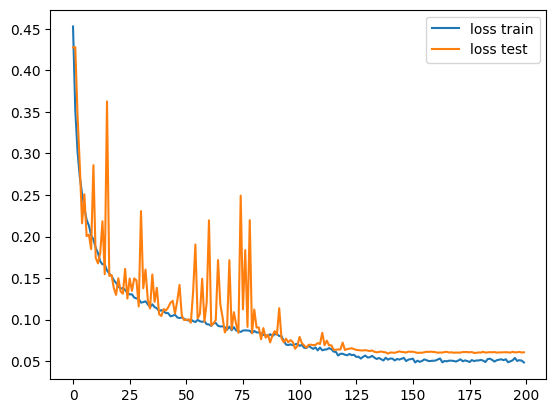

In [25]:
train_a_model_augment_on_the_fly(Model_old,train_loader,test_set,epochs =200,lr=1e-3,outmodelname='../models/fly_oldcnn.pkl')

C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


save model
Epoch : 1/200 -- Training loss 0.4305505324276306, --- Val loss 0.48584556579589844, --- accuray : 0.8178696172222837, --- recall : 0.7682306025363201
Epoch : 2/200 -- Training loss 0.3102833923445348, --- Val loss 0.6317445635795593, --- accuray : 0.8131736841013906, --- recall : 0.7351600724662902
save model
Epoch : 3/200 -- Training loss 0.26684579909364986, --- Val loss 0.42166849970817566, --- accuray : 0.8481059347263186, --- recall : 0.8070091962824084
save model
Epoch : 4/200 -- Training loss 0.24007459172328485, --- Val loss 0.25258415937423706, --- accuray : 0.9035531741143308, --- recall : 0.8990538410858464
save model
Epoch : 5/200 -- Training loss 0.21501267302191437, --- Val loss 0.21029119193553925, --- accuray : 0.9202773911314377, --- recall : 0.9194300240516277
Epoch : 6/200 -- Training loss 0.1980095539330919, --- Val loss 0.21718758344650269, --- accuray : 0.9187119828157309, --- recall : 0.9139043015105692
save model
Epoch : 7/200 -- Training loss 0.1828

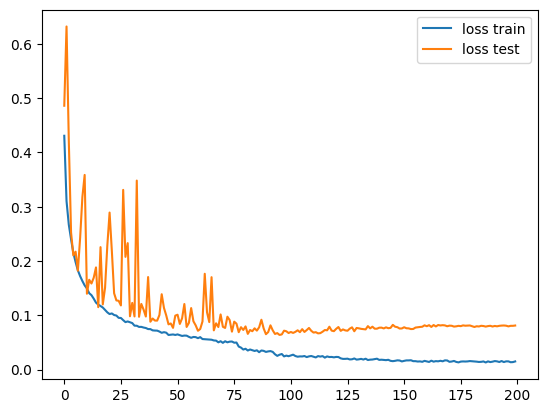

In [26]:
train_a_model_augment_on_the_fly(Model_new,train_loader,test_set,epochs =200,lr=1e-3,outmodelname='../models/fly_newcnn.pkl')

## Resultats sur la base de test

#### ancien modèle

In [27]:

X_valid, y_valid = load_balanced.load('../data/raw/mitbih_test.csv')
X_valid =np.expand_dims(X_valid,axis=1)
y_valid[y_valid>0]=1
valid_set =  TensorDataset(torch.from_numpy(X_valid).float(), torch.Tensor(torch.from_numpy(y_valid).long()))

              precision    recall  f1-score   support

           0      0.990     0.983     0.987     18118
           1      0.923     0.951     0.937      3774

    accuracy                          0.978     21892
   macro avg      0.956     0.967     0.962     21892
weighted avg      0.978     0.978     0.978     21892



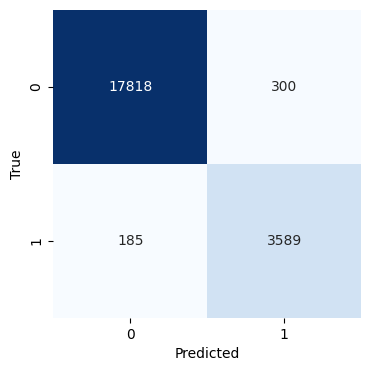

In [28]:
model_1=joblib.load('../models/fly_oldcnn.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model_1, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

#### nouveau modèle

              precision    recall  f1-score   support

           0      0.992     0.977     0.985     18118
           1      0.898     0.964     0.929      3774

    accuracy                          0.975     21892
   macro avg      0.945     0.970     0.957     21892
weighted avg      0.976     0.975     0.975     21892



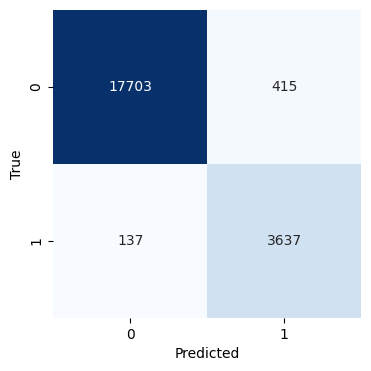

In [29]:
model_1=joblib.load('../models/fly_newcnn.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model_1, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

##  Conclusion

on arrive au même type de résultats, un peu moins bon finalement,

pour le model CNN C2: on avait :
17999 TP, 119 FP
135 FN, 3639 TN
